## Capstone 2: Fraud Detection by Rehan Khan
##### Context
There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. Financial datasets are important to many researchers and in particular to us performing research in the domain of fraud detection. Part of the problem is the intrinsically private nature of financial transactions, that leads to no publicly available datasets.

We present a synthetic dataset generated using the simulator called PaySim as an approach to such a problem. PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection methods.

##### Content
PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle.

* NOTE: Transactions which are detected as fraud are cancelled, so for fraud detection these columns (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest ) must not be used.

##### Headers
This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction.

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

##### Acknowledgements
This work is part of the research project ”Scalable resource-efficient systems for big data analytics” funded
by the Knowledge Foundation (grant: 20140032) in Sweden.

Please refer to this dataset using the following citations:

PaySim first paper of the simulator:

E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016

## 1. Data Wrangling
#### Create Dataframe

In [1]:
#Import Packages 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score,average_precision_score, confusion_matrix,
                             average_precision_score, precision_score, recall_score, roc_auc_score, classification_report, roc_curve,auc )
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

warnings.filterwarnings('ignore') 

In [2]:
#Dataframe Creation With CSV
path = 'Data\Fraud_Data.csv'
df = pd.read_csv(path)
df_save = df.copy()

#### Data Exploration

In [30]:
#Print First 10 Rows
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [31]:
#Get Datatypes and Column Names of Dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1048575 non-null  int64  
 1   type            1048575 non-null  object 
 2   amount          1048575 non-null  float64
 3   nameOrig        1048575 non-null  object 
 4   oldbalanceOrg   1048575 non-null  float64
 5   newbalanceOrig  1048575 non-null  float64
 6   nameDest        1048575 non-null  object 
 7   oldbalanceDest  1048575 non-null  float64
 8   newbalanceDest  1048575 non-null  float64
 9   isFraud         1048575 non-null  int64  
 10  isFlaggedFraud  1048575 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 88.0+ MB


In [32]:
#Print Out Number of Rows, Columns and Null Values
df_rows = df.shape[0]
df_columns = df.shape[1]
df_nulls = df.isnull().sum().sum()
print("This Fraud dataset contains {} rows, {} columns and {} null values throughout the dataset".format(df_rows, df_columns, df_nulls))

This Fraud dataset contains 1048575 rows, 11 columns and 0 null values throughout the dataset


In [33]:
#How Many Unique Customers Are in this Dataset?
num_customers = df['nameOrig'].nunique()
print("This fraud dataset contains information from {} customers using mobile money transfer".format(num_customers))

This fraud dataset contains information from 1048317 customers using mobile money transfer


In [7]:
df['isFraud'].value_counts()

isFraud
0    1047433
1       1142
Name: count, dtype: int64

#### Explore Types of Transactions in  Dataframes 

type
CASH_OUT    373641
PAYMENT     353873
CASH_IN     227130
TRANSFER     86753
DEBIT         7178
Name: count, dtype: int64

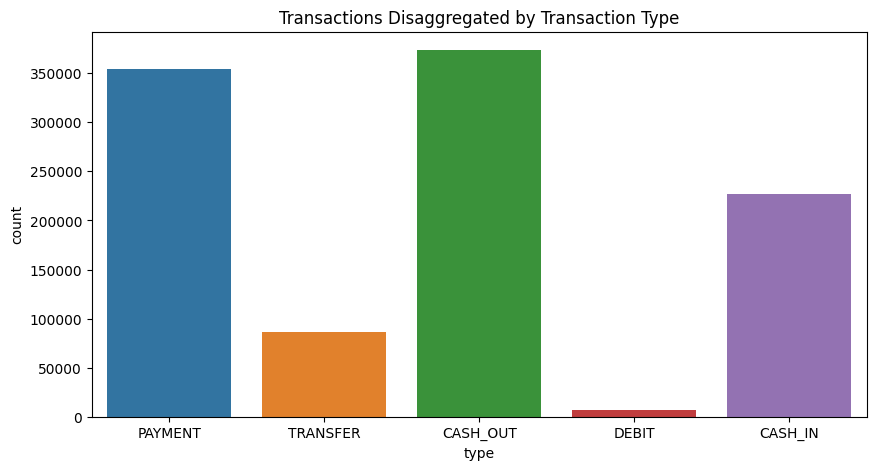

In [8]:
plt.figure(figsize=(10,5))
sns.countplot(x='type', data=df)
plt.title("Transactions Disaggregated by Transaction Type")
df['type'].value_counts()

#### Separate Fraud Data from Regular Data

In [9]:
#column of interest
col = df['isFraud']

#create variable 
df_fraud = df[col == 1]
df_notfraud = df[col== 0]

## 2. Exploratory Data Analysis

type
CASH_OUT    578
TRANSFER    564
Name: count, dtype: int64

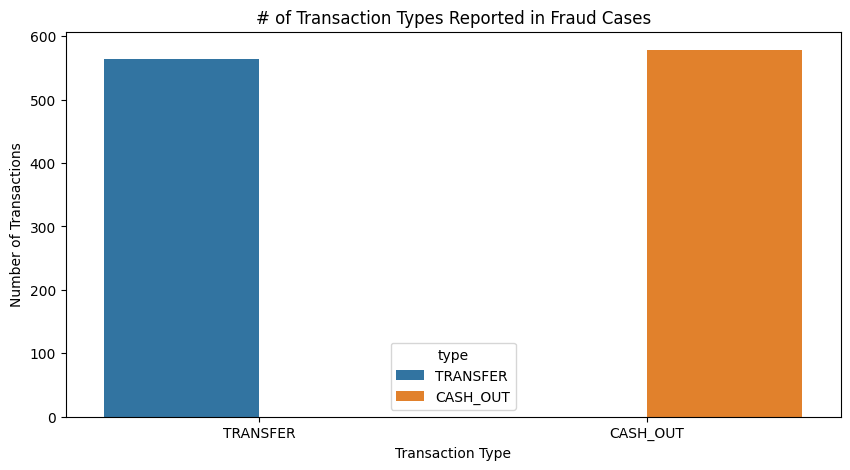

In [10]:
#Seaborn Figure for Transaction Types for Fraud Cases
plt.figure(figsize=(10,5))
sns.countplot(x='type', data=df_fraud, hue='type')
plt.xlabel("Transaction Type")
plt.ylabel('Number of Transactions')
plt.title('# of Transaction Types Reported in Fraud Cases')
df_fraud.type.value_counts()

type
CASH_OUT    373063
PAYMENT     353873
CASH_IN     227130
TRANSFER     86189
DEBIT         7178
Name: count, dtype: int64


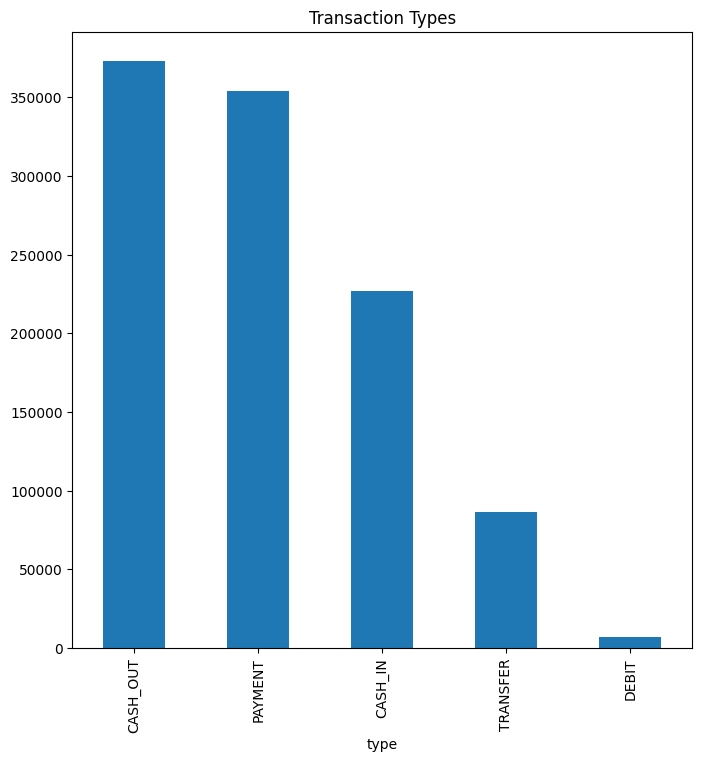

In [11]:
#Figure for Transaction Types for Non-Fraud Cases
print(df_notfraud.type.value_counts())
r, ax = plt.subplots(1, 1, figsize=(8, 8))
df_notfraud.type.value_counts().plot(kind='bar',title="Transaction Types", ax=ax, figsize=(8,8))
plt.show();

##### Transfers and Cashouts are almost equal in number in all of the fraud cases 

ValueError: could not convert string to float: 'TRANSFER'

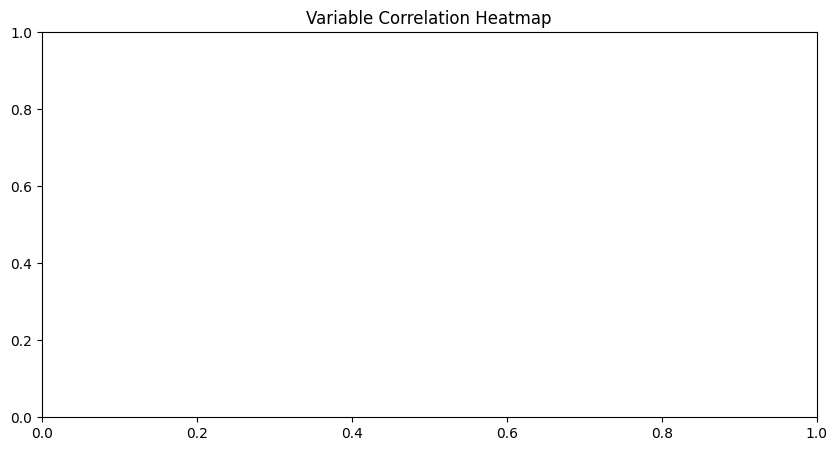

In [13]:
#heatmap of correlation within the transactions with fraud dataframe
plt.figure(figsize=(10,5))
plt.title('Variable Correlation Heatmap')
sns.heatmap(df_fraud.corr())
df_fraud.corr()

In [17]:
print('The total number of fraudulent transactions is {}.'.format(df.isFraud.sum()))
print('The total number of fraudulent transactions which is marked as fraud is {}.'.format(df.isFlaggedFraud.sum()))
print('Thus in every 773 transaction there is 1 fraud transaction happening.')
print('The total amount lost due to these fraud transaction is ${}.'.format(int(df_fraud.amount.sum())))


The total number of fraudulent transactions is 1142.
The total number of fraudulent transactions which is marked as fraud is 0.
Thus in every 773 transaction there is 1 fraud transaction happening.
The total amount lost due to these fraud transaction is $1361982240.


In [18]:
df_notfraud_amt = df_notfraud['amount']
df_notfraud_flg = df_notfraud['isFlaggedFraud']
df_fraud_amt = df_fraud['amount']
df_fraud_flg = df_fraud['isFlaggedFraud']

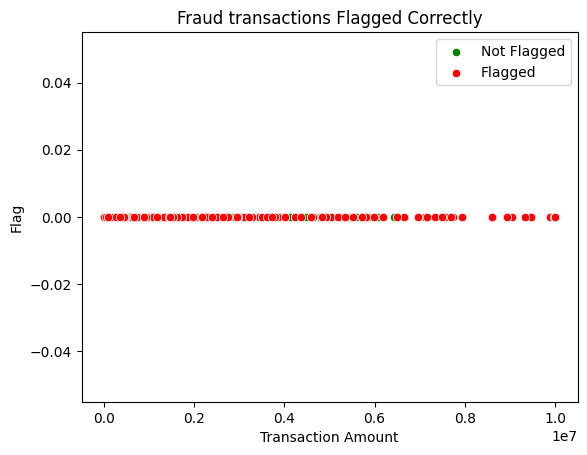

In [19]:
# Create a scatter plot using Seaborn
sns.scatterplot(x=df_notfraud_amt, y=df_notfraud_flg, color='g', label='Not Flagged')
sns.scatterplot(x=df_fraud_amt, y=df_fraud_flg, color='r', label='Flagged')

# Customize the plot
plt.title("Fraud transactions Flagged Correctly")
plt.xlabel("Transaction Amount")
plt.ylabel("Flag")
plt.legend(loc='upper right')

# Show the plot
plt.show()

#### Plot above shows that the fraud detection mechanism is not properly detecting fraud cases and we must do a deeper dive to figure out why

## 3. Pre-processing & Training Data Development

In [4]:
#initialize new column for new feature
df_copy = df_save
df_copy['Type2'] = np.nan

# filling feature column
df_copy.loc[df_copy.nameOrig.str.contains('C') & df_copy.nameDest.str.contains('C'),"Type2"] = "CC" 
df_copy.loc[df_copy.nameOrig.str.contains('C') & df_copy.nameDest.str.contains('M'),"Type2"] = "CM"
df_copy.loc[df_copy.nameOrig.str.contains('M') & df_copy.nameDest.str.contains('C'),"Type2"] = "MC"
df_copy.loc[df_copy.nameOrig.str.contains('M') & df_copy.nameDest.str.contains('M'),"Type2"] = "MM"

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Type2
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,CM
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,CM
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,CC
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,CC
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,CM
...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,95,CASH_OUT,132557.35,C1179511630,479803.00,347245.65,C435674507,484329.37,616886.72,0,0,CC
1048571,95,PAYMENT,9917.36,C1956161225,90545.00,80627.64,M668364942,0.00,0.00,0,0,CM
1048572,95,PAYMENT,14140.05,C2037964975,20545.00,6404.95,M1355182933,0.00,0.00,0,0,CM
1048573,95,PAYMENT,10020.05,C1633237354,90605.00,80584.95,M1964992463,0.00,0.00,0,0,CM


In [5]:
#drop columns that are not going to be needed
df_copy.drop(['isFlaggedFraud','nameOrig','nameDest'], axis=1, inplace=True)

In [6]:
#check dropped columns
df_copy.columns

#cols to encode
cols_encode = ['type','Type2']

#one-hot encode dataframe
df_ml = pd.get_dummies(df_copy, prefix=cols_encode)

In [7]:
#changes T/F to 1/0
df_ml = df_ml.astype(int)

##### Train-Test Split

In [18]:
#Create Separate Variables for X/Y to Prepare for Split
X = df_ml.drop('isFraud', axis=1)
y = df_ml['isFraud']

#Split variables into test and train with test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

#Normalizing Data
sc = StandardScaler()

# #apply transformations 
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


## 4. Modeling

##### Model 1: Random Forest

In [21]:
# #Train Model
RandomState = 42
RF_Params =  {'n_estimators':100,'oob_score':True,'class_weight': "balanced",'n_jobs':-1,\
                 'random_state':RandomState}
RF = RandomForestClassifier(**RF_Params)
vals_fit = RF.fit(X_train, y_train)

# #Test Set Prediction
pred_RF = RF.predict(X_test)

# Evaluating model
CM_RF = confusion_matrix(y_test,pred_RF)
CR_RF = classification_report(y_test,pred_RF)
fprRF, recallRF, thresholdsRF = roc_curve(y_test, pred_RF)
AUC_RF = auc(fprRF, recallRF)
acc = accuracy_score(y_test, pred_RF)

resultsRF = {"Confusion Matrix":CM_RF,"Classification Report":CR_RF,"Area Under Curve":AUC_RF}

In [22]:
#RF Results
for result in resultsRF:
    print(result, ': \n', resultsRF[result])

Confusion Matrix : 
 [[209516      3]
 [    45    151]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    209519
           1       0.98      0.77      0.86       196

    accuracy                           1.00    209715
   macro avg       0.99      0.89      0.93    209715
weighted avg       1.00      1.00      1.00    209715

Area Under Curve : 
 0.8851969223774067


##### Model 2: Decision Tree Classifier

In [23]:
from sklearn.tree import DecisionTreeClassifier

# Train model
DT = DecisionTreeClassifier()
fitted_vals = DT.fit(X_train, y_train)
 
# Predict on testing set
predictionsDT = DT.predict(X_test)
 
     
# Evaluating model
CM_DT = confusion_matrix(y_test,predictionsDT)
CR_DT = classification_report(y_test,predictionsDT)
fprDT, recallDT, thresholdsDT = roc_curve(y_test, predictionsDT)
AUC_DT = auc(fprDT, recallDT)

resultsDT = {"Confusion Matrix":CM_DT,"Classification Report":CR_DT,"Area Under Curve":AUC_DT}

# showing results from DT
for measure in resultsDT:
    print(measure,": \n",resultsDT[measure])

Confusion Matrix : 
 [[209479     40]
 [    35    161]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    209519
           1       0.80      0.82      0.81       196

    accuracy                           1.00    209715
   macro avg       0.90      0.91      0.91    209715
weighted avg       1.00      1.00      1.00    209715

Area Under Curve : 
 0.9106188289776651


##### Model 3: Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression

#create model
log_reg = LogisticRegression()
lr_model = log_reg.fit(X_train, y_train)

#predict values
Y_pred = lr_model.predict(X_test)

#check classification report
print(classification_report(y_test, Y_pred, target_names=['Not Fraud','Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    209519
       Fraud       0.51      0.30      0.38       196

    accuracy                           1.00    209715
   macro avg       0.76      0.65      0.69    209715
weighted avg       1.00      1.00      1.00    209715



## Model Evaluation

In [ ]:
rfc=RandomForestClassifier(n_estimators = 15, n_jobs = -1, random_state = 42)
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)
rfc_pred_proba = rfc.predict_proba(X_test)[:,1]

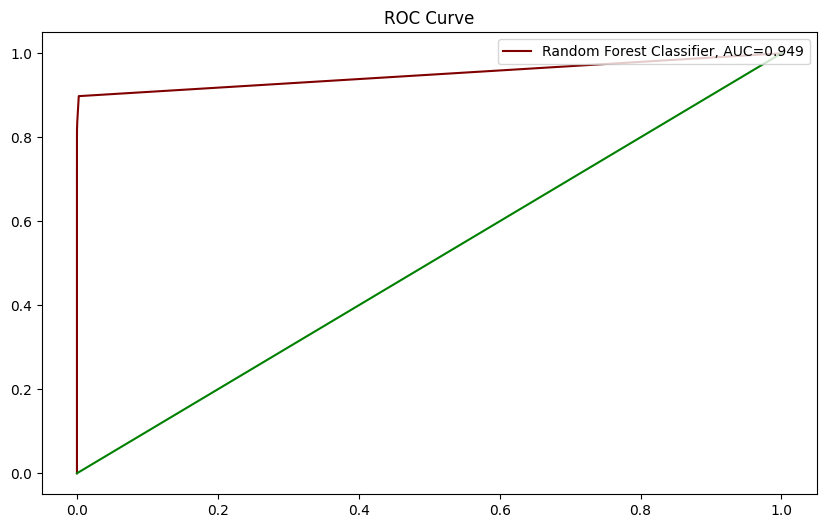

In [33]:
fpr, tpr, temp = roc_curve(y_test, rfc_pred_proba)
auc = round(roc_auc_score(y_test, rfc_pred_proba),3)
plt.figure(figsize=(10,6))
plt.plot(fpr,tpr,label='Random Forest Classifier, AUC='+str(auc),linestyle='solid',color='#800000')
plt.plot([0, 1], [0, 1], color = 'g')
plt.title('ROC Curve')
plt.legend(loc='upper right');

##### The total number of fraud transactions were 1142 transactions. These fraud transactions were either Transfer or Debits. In this capstone project we trained the following algorithms:

##### 1. Random Forest
##### 2. Decision Tree
##### 3. Logistic Regression

##### We found that the Random Forest Algorithm Performed the best out of the three algorithms with an AUC score of 0.949.